In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

from gcn import SimpleGCN

## 1. Extract data

In [2]:
DATA_PATH = "datas.txt"
LABEL_PATH = "labels.txt"

In [3]:
def extract_datas(data_path: str, label_path: str):

    # load data
    with open(data_path, "r") as ftxt:
        datas = ftxt.read().split('\n')

    # load label
    with open(label_path, "r") as ftxt:
        labels = ftxt.read().split('\n')
    labels = [int(x) for x in labels]
    
    print("total nodes: ", len(datas))
    print("total labels:", len(labels))

    adjacency_matrix = []
    for data in datas:
        conns = data.split(' ')
        adjacency_matrix.append([int(x) for x in conns])

    adjacency_matrix = torch.tensor(adjacency_matrix)
    labels = torch.tensor(labels)
    print("Adjacency Matrix:", adjacency_matrix.size())

    return adjacency_matrix, labels

### get adjacency matrix and labels of data

In [4]:
adjacency_matrix, labels = extract_datas(DATA_PATH, LABEL_PATH)

total nodes:  34
total labels: 34
Adjacency Matrix: torch.Size([34, 34])


## 2. Visualization

In [5]:
COLORS = ['green', 'red', 'blue', 'purple']

In [6]:
def visualize(adjacency_matrix, labels):

    labels_dict = {}
    colors = []
    for i in range(labels.size(0)):
        labels_dict[str(i)] = i
        colors.append(COLORS[int(labels[i])])

    rows, cols = torch.where(adjacency_matrix == 1)
    rows = [str(x) for x in rows.tolist()]
    cols = [str(x) for x in cols.tolist()]
    edges = zip(rows, cols)

    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, node_color=colors, labels=labels_dict, with_labels=True)
    plt.show()

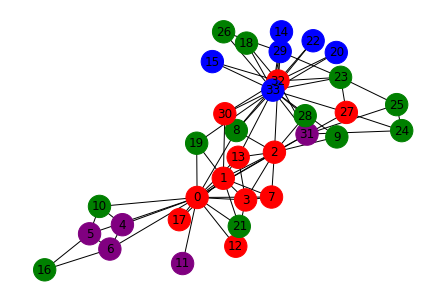

In [7]:
visualize(adjacency_matrix, labels)

## 3. Model

In [8]:
# get training device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("use device:", device)

use device: cuda:0


In [9]:
model = SimpleGCN(
        adj=adjacency_matrix.float().to(device),
        num_class=4)
model.to(device)

SimpleGCN(
  (layer_1): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
  (relu): Tanh()
)

## 4. Train

### 4.1. preprocess data, adjacency and label

In [10]:
num_nodes = adjacency_matrix.size(0)
adjacency_matrix = adjacency_matrix + torch.eye(num_nodes) # with self-connection
adjacency_matrix = adjacency_matrix / 34
# unsqueeze(0): add batch dimension (for pytorch training).
# unsqueeze(0): add channels.
datas = torch.ones(num_nodes).unsqueeze(0).unsqueeze(0)

# put data and label to gpu
datas, labels = datas.to(device), labels.to(device)

In [11]:
print("data size:", datas.size())
print("adjacency_matrix size:", adjacency_matrix.size())
print("labels size:", labels.size())

data size: torch.Size([1, 1, 34])
adjacency_matrix size: torch.Size([34, 34])
labels size: torch.Size([34])


### 4.2. create optimizer and criterion

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

### 4.3 train

In [13]:
MAX_EPOCHS = 3600

In [14]:
def train(epoch, model, optimizer, criterion, data, label):
    model.train()
    out = model(data)
    # out: (1, 4, 34)
    # ---> (34, 4)
    out = out.squeeze(0).transpose(1, 0)
    loss = criterion(out, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # msic...
    if (epoch+1) % 100 == 0:
        corrects = torch.max(out, dim=-1)[1].eq(label).cpu().sum().item()
        train_acc = float(corrects / out.size(0))

        print("epoch:{:.1E}, loss:{}, accuracy:{}".format(
            epoch+1, float(loss), round(100*train_acc, 2)
        ))

In [15]:
for epoch in range(MAX_EPOCHS):
    train(epoch, model, optimizer, criterion, datas, labels)

epoch:1.0E+02, loss:1.2685942649841309, accuracy:50.0
epoch:2.0E+02, loss:1.2118123769760132, accuracy:55.88
epoch:3.0E+02, loss:1.1274763345718384, accuracy:64.71
epoch:4.0E+02, loss:1.0595457553863525, accuracy:70.59
epoch:5.0E+02, loss:1.0333105325698853, accuracy:70.59
epoch:6.0E+02, loss:1.0093927383422852, accuracy:67.65
epoch:7.0E+02, loss:0.985156238079071, accuracy:73.53
epoch:8.0E+02, loss:0.9538193941116333, accuracy:79.41
epoch:9.0E+02, loss:0.9305872917175293, accuracy:79.41
epoch:1.0E+03, loss:0.904289960861206, accuracy:76.47
epoch:1.1E+03, loss:0.8557637333869934, accuracy:76.47
epoch:1.2E+03, loss:0.830544114112854, accuracy:79.41
epoch:1.3E+03, loss:0.8103194236755371, accuracy:79.41
epoch:1.4E+03, loss:0.7927058339118958, accuracy:79.41
epoch:1.5E+03, loss:0.7743050456047058, accuracy:79.41
epoch:1.6E+03, loss:0.756824791431427, accuracy:79.41
epoch:1.7E+03, loss:0.7396379113197327, accuracy:82.35
epoch:1.8E+03, loss:0.7229093313217163, accuracy:79.41
epoch:1.9E+03, 